# Computational Analysis

## Setup

In [ ]:
!pip install pyLDAvis

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import warnings

nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(12,6)})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Dataset Overview

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/javi-ng/datasets/main/CSCI%20161%20Project%20Datasets/clean_df_v2.csv')
df

Platform                                    Game       Team  \
0      Facebook    Tottenham vs. Liverpool September 30  Tottenham   
1      Facebook    Tottenham vs. Liverpool September 30  Tottenham   
2      Facebook    Tottenham vs. Liverpool September 30  Tottenham   
3      Facebook    Tottenham vs. Liverpool September 30  Tottenham   
4      Facebook    Tottenham vs. Liverpool September 30  Tottenham   
...         ...                                     ...        ...   
45523   Youtube  Manchester United vs. Wolves August 15     Wolves   
45524   Youtube  Manchester United vs. Wolves August 15     Wolves   
45525   Youtube  Manchester United vs. Wolves August 15     Wolves   
45526   Youtube  Manchester United vs. Wolves August 15     Wolves   
45527   Youtube  Manchester United vs. Wolves August 15     Wolves   

                                            cleaned_text  
0      id completely embarrass celebrate win disallow...  
1                  get lucky men side need goal win coys  
2                                                   coys  
3                                          trust process  
4      important point lucky tonight sometimes go way...  
...                                                  ...  
45523  brilliant save jose sa open day wolverhampton ...  
45524                                          first one  
45525                                              shame  
45526                             wolf deserve win today  
45527                                          first pin  

[45528 rows x 4 columns]

## Dataset resplitting

Lists for making dataframe dictionary

In [ ]:
fbteams = ['Tottenham', 'Liverpool', 'Tottenham', 'Liverpool']
fbgames = [
            'Tottenham vs. Liverpool September 30', 'Tottenham vs. Liverpool September 30',
            'Tottenham vs. Liverpool May 1', 'Tottenham vs. Liverpool May 1'
          ]
ytteams = ['Tottenham', 'Liverpool', 'Tottenham', 'Liverpool', 'Wolves', 'Manchester', 'Manchester', 'Wolves']
ytgames = [
    'Tottenham vs. Liverpool September 30', 'Tottenham vs. Liverpool September 30',
    'Tottenham vs. Liverpool May 1', 'Tottenham vs. Liverpool May 1',
    'Manchester United vs. Wolves May 14', 'Manchester United vs. Wolves May 14',
    'Manchester United vs. Wolves August 15', 'Manchester United vs. Wolves August 15'
    ]
teams = fbteams + ytteams
games = fbgames + ytgames
team_game_list = list(zip(teams, games))

Making a dictionary, then assigning each game-team pair to a dateframe with corresponding comments:

In [ ]:
dfDict = {}
for pair in team_game_list:
  label = pair[1] + ', ' + pair[0]
  dfDict[label] = df.loc[(df['Team'] == pair[0]) & (df['Game'] == pair[1])]

Adding dataframes for each team's comments overall:

In [ ]:
for team in set(teams):
  label = team
  dfDict[label] = df.loc[(df['Team'] == team)]

# Method Definition

## Wordcloud

In [ ]:
wc = WordCloud(background_color="white", max_words=100)
def wordcloudify(df):
  raw_text = ' '.join(df['cleaned_text']).replace(' ', ',')
  wc.generate(raw_text)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  plt.close()

## Topic Modeling

In [ ]:
vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, stop_words = stopwords)

In [ ]:
def topic_model(df, topics: int):
  LDA = LatentDirichletAllocation(n_components=topics, random_state = 10)
  doc_term_matrix = vectorizer.fit_transform(df['cleaned_text'])
  LDA.fit(doc_term_matrix)
  topic_term_matrix = LDA.components_
  doc_topic_matrix = LDA.transform(doc_term_matrix)

  vocab = vectorizer.get_feature_names_out()
  doc_lengths = [len(doc) for doc in df['cleaned_text']]
  term_freqs = doc_term_matrix.sum(axis=0)
  term_freqs = np.array(term_freqs).flatten()

  newdf = df.copy()
  newdf['Topic'] = doc_topic_matrix.argmax(axis=1)
  return newdf, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs

## Sentiment Analysis

In [ ]:
nltk.download(["vader_lexicon"])
from nltk.sentiment import SentimentIntensityAnalyzer
senti = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Function to perform sentiment analysis
def sentiment_analysis(dataframe, textcolumn='cleaned_text'):
  for index, row in dataframe.iterrows():                       # iterate the rows of the dataframe
    senti_score = senti.polarity_scores(str(row[textcolumn]))   # get the sentiment scores
    dataframe.loc[index,'neg'] = senti_score['neg']             # append the negative score
    dataframe.loc[index,'neu'] = senti_score['neu']             # append the neutral score
    dataframe.loc[index,'pos'] = senti_score['pos']             # append the positive score
    dataframe.loc[index,'compound'] = senti_score['compound']   # append the compound score
  return dataframe

In [ ]:
def sentimentalize(df, ogdf):
  for index in df.index:
    emotions = [df.at[index, 'neg'], df.at[index, 'neu'], df.at[index, 'pos']]
    if max(emotions) == emotions[1]:
      sentiment = 'neutral'
      ind = 1
    elif max(emotions) == emotions[0]:
      sentiment = 'negative'
      ind = 0
    elif max(emotions) == emotions[2]:
      sentiment = 'positive'
      ind = 2
    ogdf.loc[index, 'sentiment'] = sentiment
    ogdf.loc[index, 'sentiment_confidence'] = emotions[ind]

## Term-Based frequency Analysis

In [ ]:
def frequency_df(df, n):
  vectorizer = CountVectorizer(stop_words=stopwords,ngram_range=(n,n),max_features=2000)
  matrix = vectorizer.fit_transform(df['cleaned_text'])
  total = matrix.sum(axis=0)
  frequency = [(w, total[0, i]) for w, i in vectorizer.vocabulary_.items()]
  frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
  frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
  return frequency

In [ ]:
def visualize_frequency(matrix, vectorizer, title=None):
    total = matrix.sum(axis=0)
    frequency = [(w, total[0, i]) for w, i in vectorizer.vocabulary_.items()]
    frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
    frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
    ax = sns.barplot(data=frequency.head(25), x='term', y='frequency')
    if title:
        ax.set_title(title)
    plt.xticks(rotation=45)
    plt.show()
    plt.close()

In [ ]:
def visualize_terms(df):
    vectorizer_1gram = CountVectorizer(stop_words=stopwords,ngram_range=(1,1),max_features=2000)
    matrix_1gram = vectorizer_1gram.fit_transform(df['cleaned_text'])
    vectorizer_2gram = CountVectorizer(stop_words=stopwords,ngram_range=(2,2),max_features=2000)
    matrix_2gram = vectorizer_2gram.fit_transform(df['cleaned_text'])
    visualize_frequency(matrix_1gram, vectorizer_1gram)
    visualize_frequency(matrix_2gram, vectorizer_2gram)

# Tottenham Data

## All Tottenham Data

In [ ]:
current_df = dfDict['Tottenham']

### Wordcloud

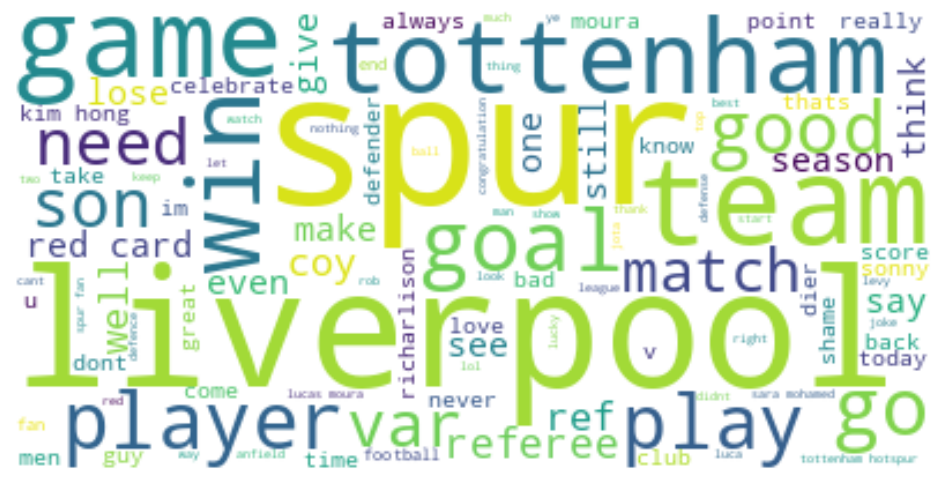

In [ ]:
wordcloudify(current_df)

### Topic Modeling

In [ ]:
tottenTopic, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

### Sentiment Analysis

In [ ]:
tottenham_sentiment = sentiment_analysis(current_df)

In [ ]:
tottenham_sentiment.groupby('Game').describe()

neg                                \
                                       count      mean       std  min  25%   
Game                                                                         
Tottenham vs. Liverpool May 1         4478.0  0.132714  0.216459  0.0  0.0   
Tottenham vs. Liverpool September 30  7725.0  0.124678  0.221735  0.0  0.0   

                                                          neu            ...  \
                                      50%    75%  max   count      mean  ...   
Game                                                                     ...   
Tottenham vs. Liverpool May 1         0.0  0.223  1.0  4478.0  0.687427  ...   
Tottenham vs. Liverpool September 30  0.0  0.194  1.0  7725.0  0.656094  ...   

                                        pos      compound                      \
                                        75%  max    count      mean       std   
Game                                                                            
Tottenham vs. Liverpool May 1         0.326  1.0   4478.0  0.060409  0.400308   
Tottenham vs. Liverpool September 30  0.412  1.0   7725.0  0.125409  0.424505   

                                                                           
                                         min     25%  50%     75%     max  
Game                                                                       
Tottenham vs. Liverpool May 1        -0.9761 -0.0258  0.0  0.3400  0.9964  
Tottenham vs. Liverpool September 30 -0.9917  0.0000  0.0  0.4509  0.9980  

[2 rows x 32 columns]

In [ ]:
tottenSenti = current_df.copy()
sentimentalize(tottenham_sentiment, tottenSenti)
tottenSenti[['Game', 'sentiment']].groupby('Game').value_counts().reset_index()

Game sentiment  count
0         Tottenham vs. Liverpool May 1   neutral   3408
1         Tottenham vs. Liverpool May 1  positive    615
2         Tottenham vs. Liverpool May 1  negative    455
3  Tottenham vs. Liverpool September 30   neutral   5382
4  Tottenham vs. Liverpool September 30  positive   1593
5  Tottenham vs. Liverpool September 30  negative    750

### Term-frequency Analysis

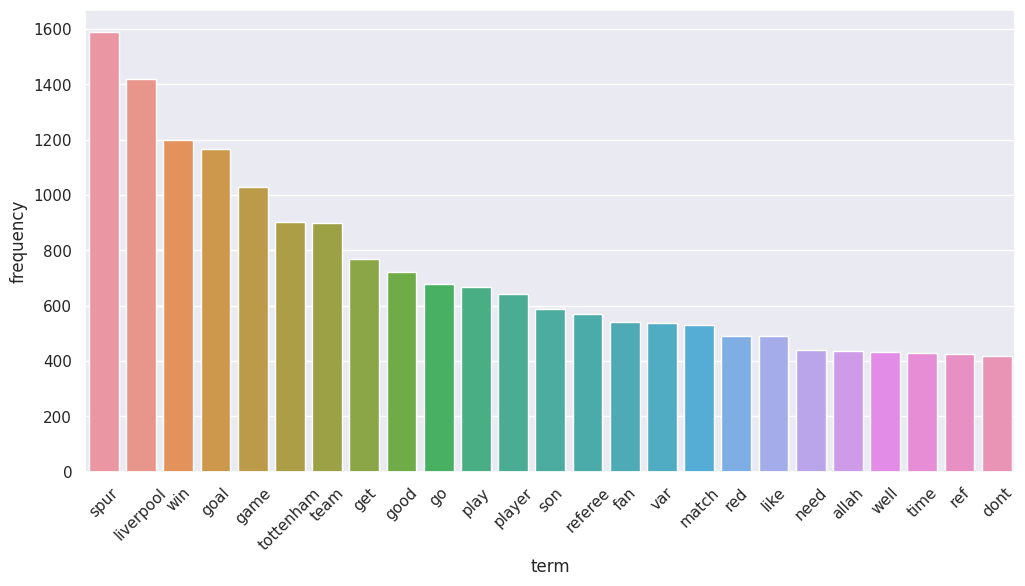

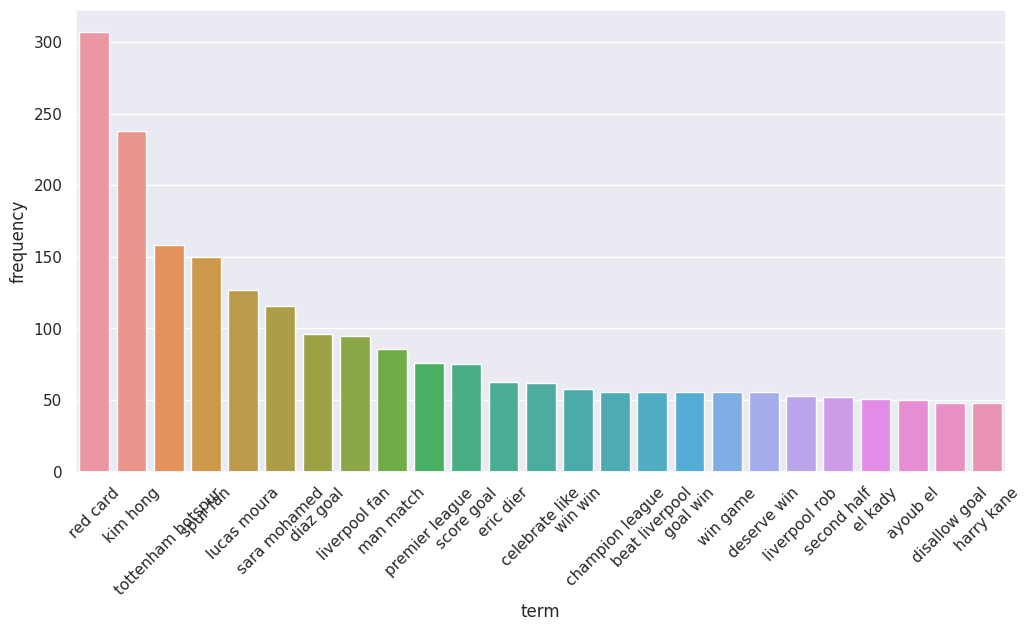

In [ ]:
visualize_terms(current_df)

In [ ]:
frequency_df(current_df, 1).head(10)

In [ ]:
frequency_df(current_df, 2).head(10)

## Tottenham Controversial Data

In [ ]:
current_df = dfDict['Tottenham vs. Liverpool September 30, Tottenham']

### Wordcloud

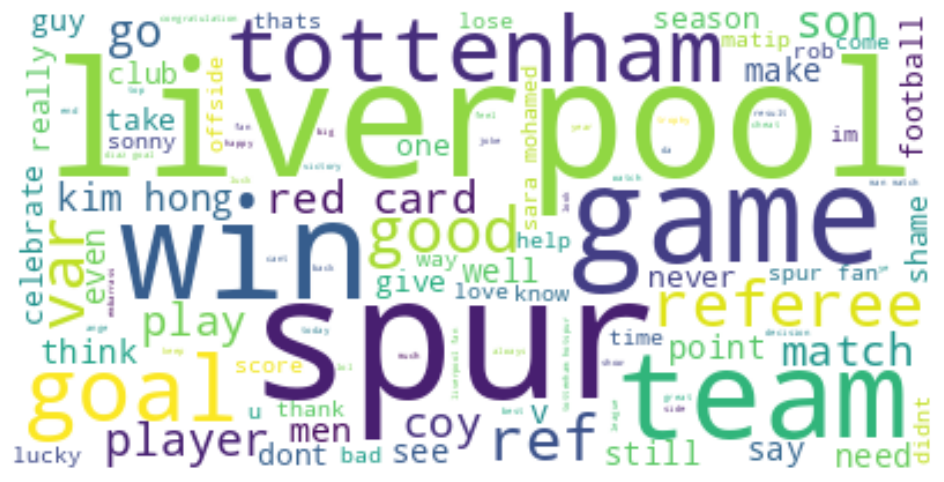

In [ ]:
wordcloudify(current_df)

### Term-frequency Analysis

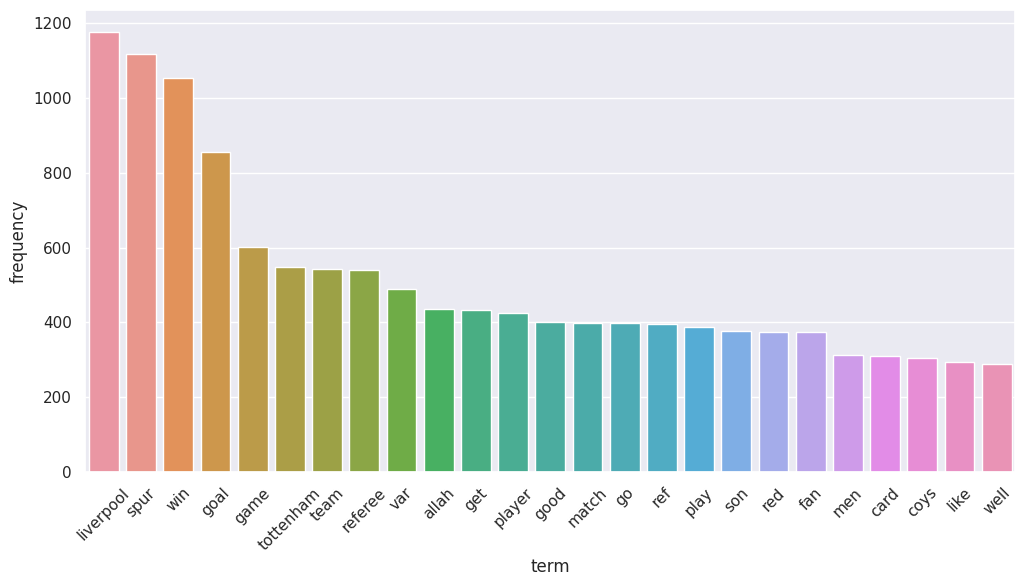

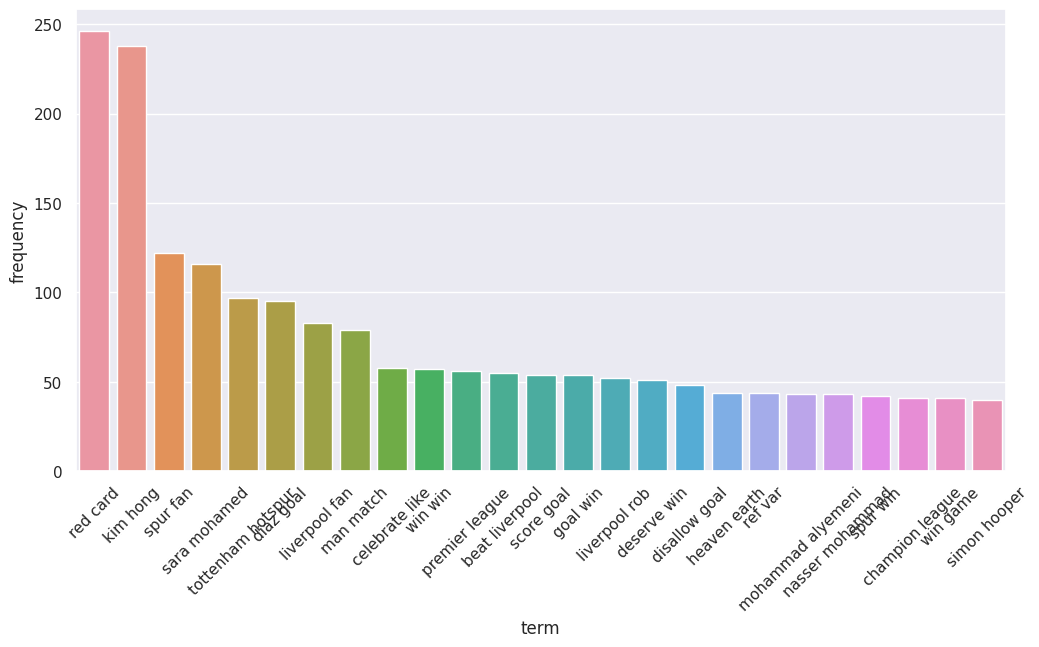

In [ ]:
visualize_terms(current_df)

In [ ]:
frequency_df(current_df, 1).head(10)

term  frequency
0  liverpool       1177
1       spur       1118
2        win       1053
3       goal        855
4       game        602
5  tottenham        548
6       team        542
7    referee        540
8        var        489
9      allah        435

In [ ]:
frequency_df(current_df, 2).head(10)

term  frequency
0           red card        246
1           kim hong        238
2           spur fan        122
3       sara mohamed        116
4  tottenham hotspur         97
5          diaz goal         95
6      liverpool fan         83
7          man match         79
8     celebrate like         58
9            win win         57

### Topic Modeling

In [ ]:
tottenCTopic, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

In [ ]:
tottenCTopic.value_counts('Topic').reset_index()

Topic  count
0      2   3888
1      0   3084
2      1    753

## Tottenham Non-Controversial Data

In [ ]:
current_df = dfDict['Tottenham vs. Liverpool May 1, Tottenham']

### Wordcloud

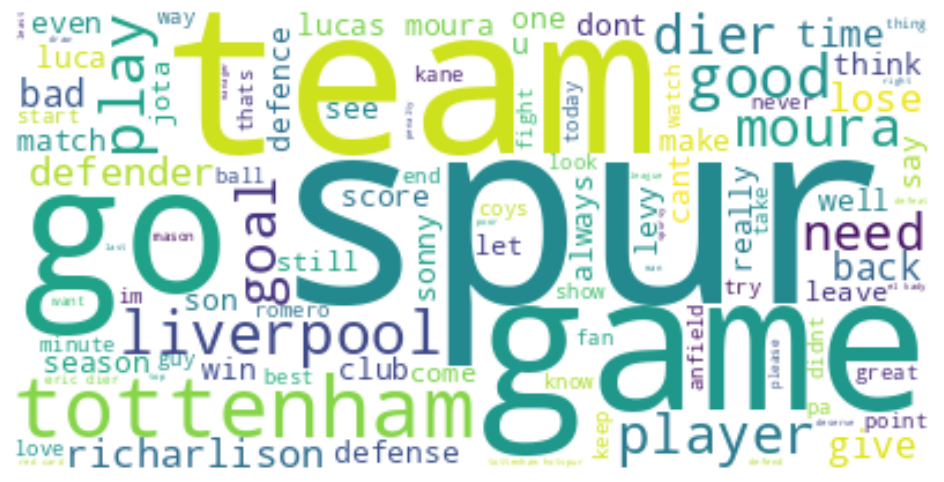

In [ ]:
wordcloudify(current_df)

### Term-frequency analysis

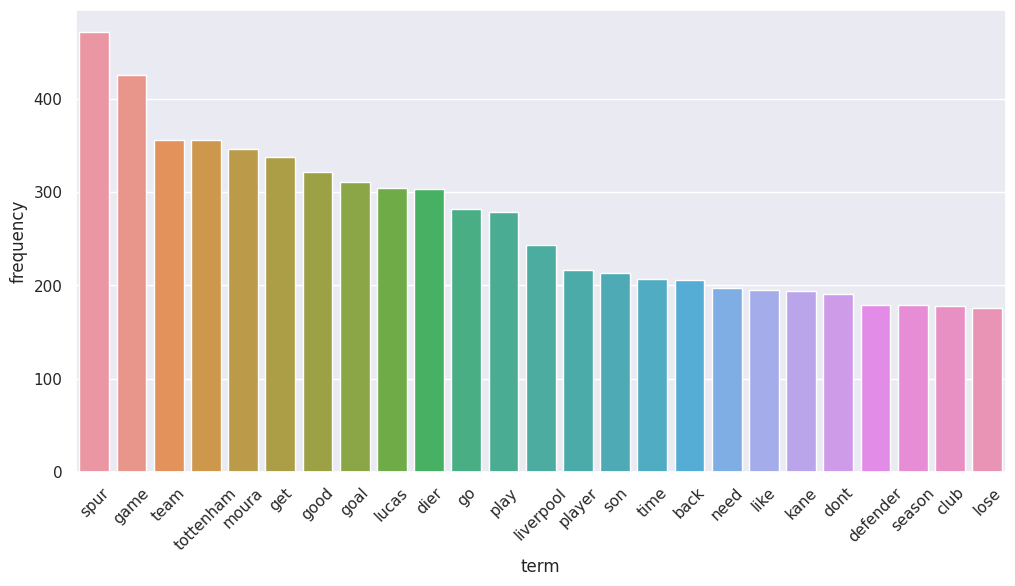

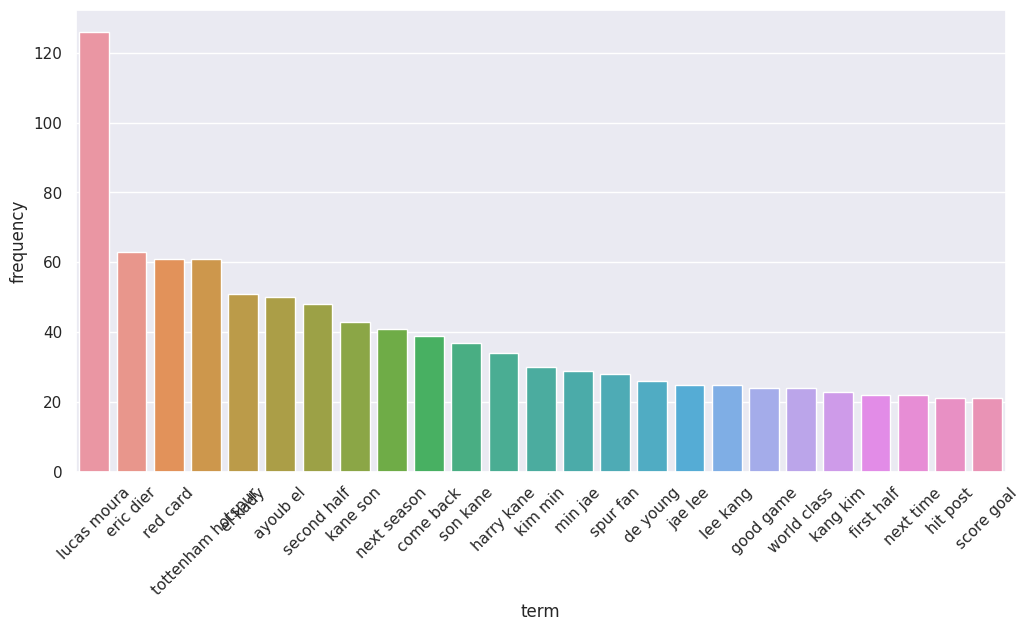

In [ ]:
visualize_terms(current_df)

In [ ]:
frequency_df(current_df, 1).head(10)

term  frequency
0       spur        472
1       game        426
2       team        356
3  tottenham        356
4      moura        346
5        get        338
6       good        322
7       goal        311
8      lucas        304
9       dier        303

In [ ]:
frequency_df(current_df, 2).head(10)

term  frequency
0        lucas moura        126
1          eric dier         63
2           red card         61
3  tottenham hotspur         61
4            el kady         51
5           ayoub el         50
6        second half         48
7           kane son         43
8        next season         41
9          come back         39

### Topic Modeling

In [ ]:
tottenNCTopic, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

In [ ]:
tottenNCTopic.value_counts('Topic').reset_index()

Topic  count
0      2   1666
1      1   1554
2      0   1258

# Liverpool Data

## All Liverpool Data

In [ ]:
current_df = dfDict['Liverpool']

### Wordcloud

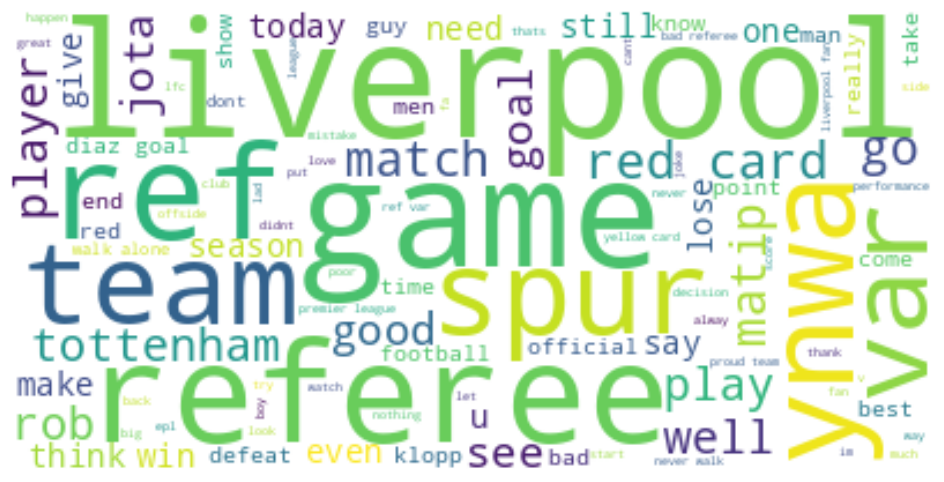

In [ ]:
wordcloudify(current_df)

### Topic Modeling

In [ ]:
liverTopics, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

### Sentiment Analysis

In [ ]:
liverpool_analysis = sentiment_analysis(current_df)
liverpool_analysis

Platform                                  Game       Team  \
4914   Facebook  Tottenham vs. Liverpool September 30  Liverpool   
4915   Facebook  Tottenham vs. Liverpool September 30  Liverpool   
4916   Facebook  Tottenham vs. Liverpool September 30  Liverpool   
4917   Facebook  Tottenham vs. Liverpool September 30  Liverpool   
4918   Facebook  Tottenham vs. Liverpool September 30  Liverpool   
...         ...                                   ...        ...   
42007   Youtube         Tottenham vs. Liverpool May 1  Liverpool   
42008   Youtube         Tottenham vs. Liverpool May 1  Liverpool   
42009   Youtube         Tottenham vs. Liverpool May 1  Liverpool   
42010   Youtube         Tottenham vs. Liverpool May 1  Liverpool   
42011   Youtube         Tottenham vs. Liverpool May 1  Liverpool   

                                            cleaned_text    neg    neu    pos  \
4914   use think liverpool football club finish wrong...  0.279  0.721  0.000   
4915   nothing respect boy matip unlucky jota pure st...  0.582  0.418  0.000   
4916   didnt deserve today feel matip superb dont kno...  0.085  0.667  0.248   
4917   yes red great fight var official ashamed immed...  0.308  0.324  0.368   
4918                         matip good unfortunate goal  0.380  0.253  0.367   
...                                                  ...    ...    ...    ...   
42007                                   never walk alone  0.000  0.535  0.465   
42008                  inappropriate game anxious people  0.400  0.600  0.000   
42009                                   diogooooooo love  0.000  0.192  0.808   
42010                                              proud  0.000  0.000  1.000   
42011  jota player make difference without doubt retu...  0.186  0.512  0.302   

       compound  
4914    -0.4767  
4915    -0.9110  
4916     0.5719  
4917     0.2732  
4918    -0.0258  
...         ...  
42007    0.1877  
42008   -0.2500  
42009    0.6369  
42010    0.4767  
42011    0.2592  

[29809 rows x 8 columns]

In [ ]:
liverpool_analysis.groupby('Game').describe()

neg                                \
                                        count      mean       std  min  25%   
Game                                                                          
Tottenham vs. Liverpool May 1          5813.0  0.105803  0.200450  0.0  0.0   
Tottenham vs. Liverpool September 30  23996.0  0.160027  0.240412  0.0  0.0   

                                                           neu            ...  \
                                      50%    75%  max    count      mean  ...   
Game                                                                      ...   
Tottenham vs. Liverpool May 1         0.0  0.152  1.0   5813.0  0.692387  ...   
Tottenham vs. Liverpool September 30  0.0  0.282  1.0  23996.0  0.652073  ...   

                                        pos      compound                      \
                                        75%  max    count      mean       std   
Game                                                                            
Tottenham vs. Liverpool May 1         0.380  1.0   5813.0  0.112035  0.389799   
Tottenham vs. Liverpool September 30  0.351  1.0  23996.0  0.041968  0.422759   

                                                                           
                                         min     25%  50%     75%     max  
Game                                                                       
Tottenham vs. Liverpool May 1        -0.9623  0.0000  0.0  0.4215  0.9854  
Tottenham vs. Liverpool September 30 -0.9786 -0.2023  0.0  0.3612  0.9962  

[2 rows x 32 columns]

In [ ]:
liverSenti = current_df.copy()
sentimentalize(liverpool_analysis, liverSenti)
liverSenti[['Game', 'sentiment']].groupby('Game').value_counts().reset_index()

Game sentiment  count
0         Tottenham vs. Liverpool May 1   neutral   4339
1         Tottenham vs. Liverpool May 1  positive   1018
2         Tottenham vs. Liverpool May 1  negative    456
3  Tottenham vs. Liverpool September 30   neutral  16938
4  Tottenham vs. Liverpool September 30  positive   3980
5  Tottenham vs. Liverpool September 30  negative   3078

In [ ]:
l_affect = affect_analysis(current_df)
l_affect.groupby('Game').describe()

positive_affect                           \
                                               count      mean       std  min   
Game                                                                            
Tottenham vs. Liverpool May 1                 5813.0  0.117131  0.203728  0.0   
Tottenham vs. Liverpool September 30         23996.0  0.101987  0.189170  0.0   

                                                              negative_affect  \
                                      25%  50%       75%  max           count   
Game                                                                            
Tottenham vs. Liverpool May 1         0.0  0.0  0.200000  1.0          5813.0   
Tottenham vs. Liverpool September 30  0.0  0.0  0.166667  1.0         23996.0   

                                                ... surprise_affect       \
                                          mean  ...             75%  max   
Game                                            ...                        
Tottenham vs. Liverpool May 1         0.106357  ...             0.0  1.0   
Tottenham vs. Liverpool September 30  0.130449  ...             0.0  1.0   

                                     anticip_affect                           \
                                              count mean  std  min  25%  50%   
Game                                                                           
Tottenham vs. Liverpool May 1                5813.0  0.0  0.0  0.0  0.0  0.0   
Tottenham vs. Liverpool September 30        23996.0  0.0  0.0  0.0  0.0  0.0   

                                                
                                      75%  max  
Game                                            
Tottenham vs. Liverpool May 1         0.0  0.0  
Tottenham vs. Liverpool September 30  0.0  0.0  

[2 rows x 72 columns]

### Term-frequency based analysis

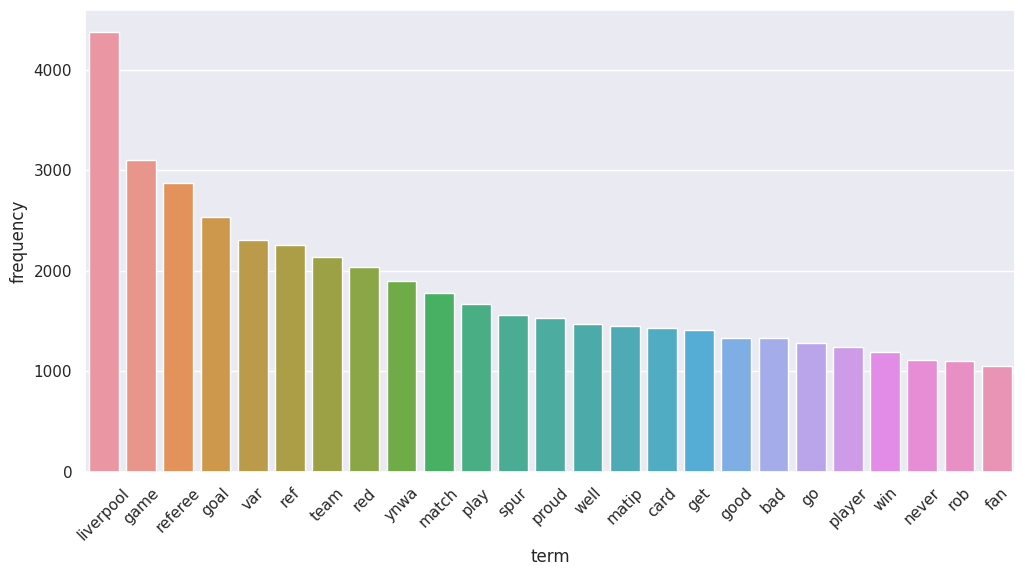

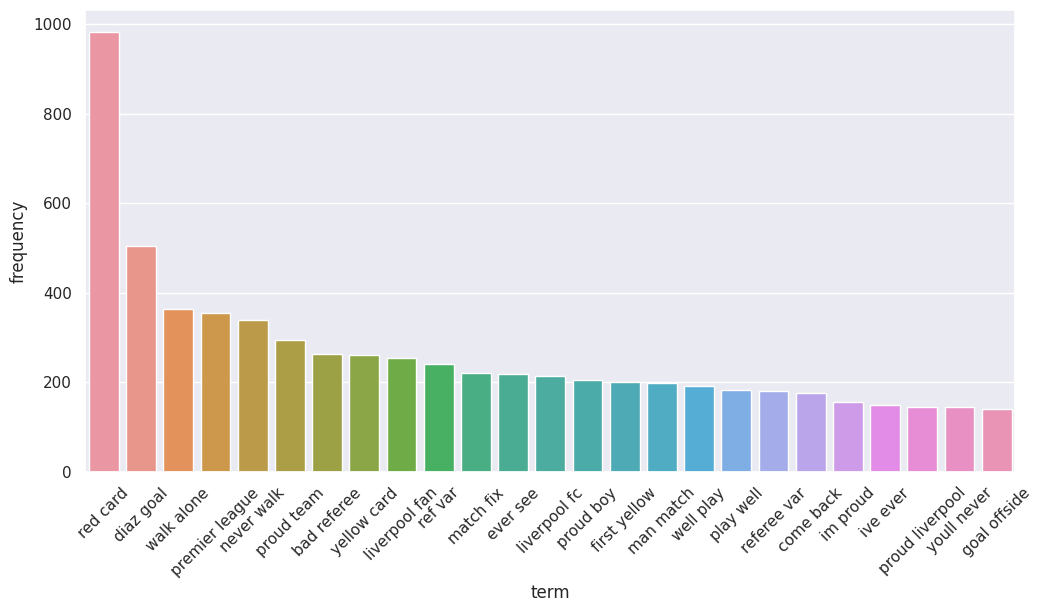

In [ ]:
visualize_terms(current_df)

## Liverpool Controversial Data

In [ ]:
current_df = dfDict['Tottenham vs. Liverpool September 30, Liverpool']

### Wordcloud

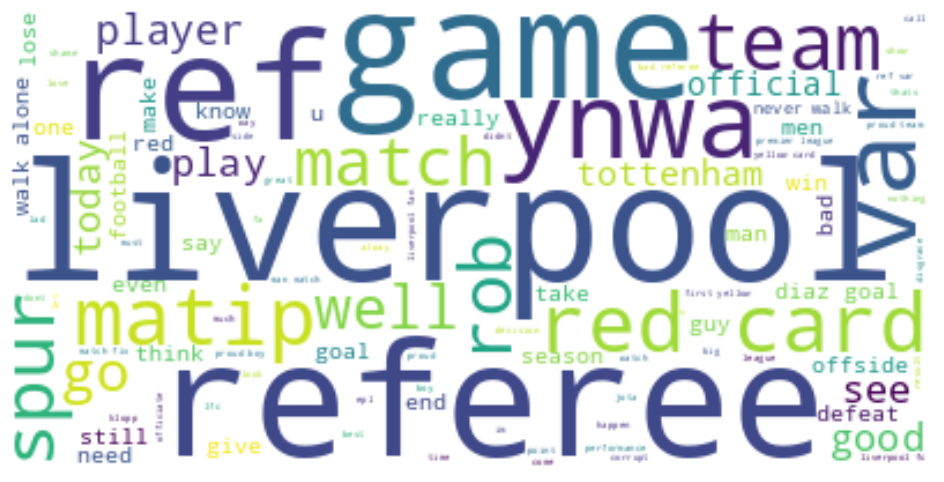

In [ ]:
wordcloudify(current_df)

### Term-frequency analysis

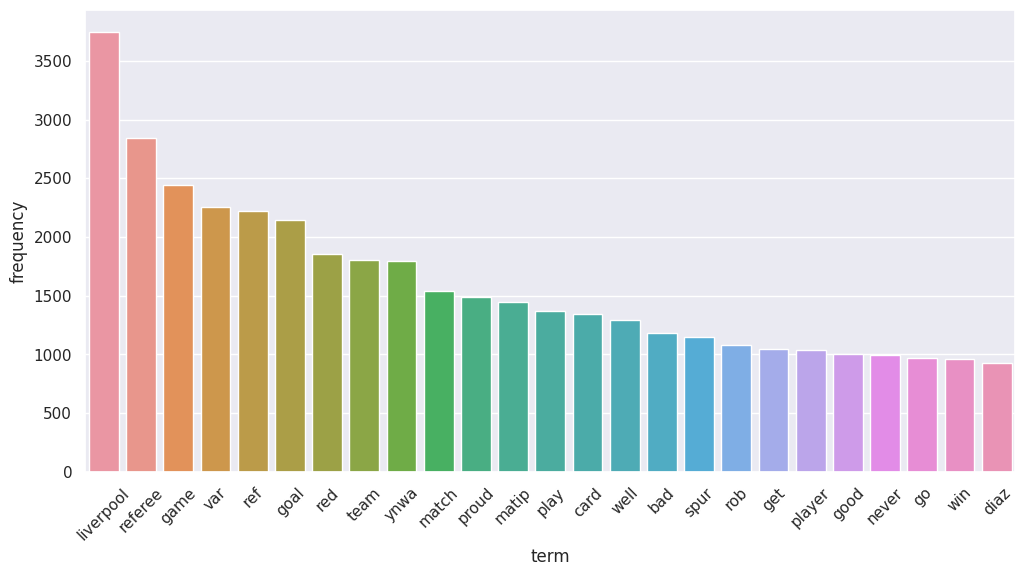

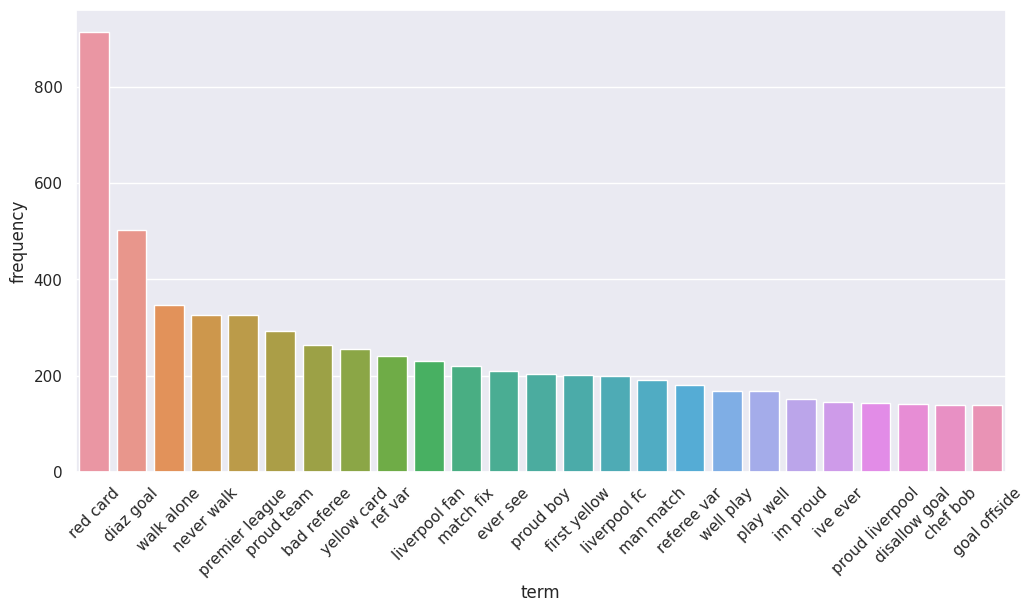

In [ ]:
visualize_terms(current_df)

In [ ]:
frequency_df(current_df, 1).head(10)

term  frequency
0  liverpool       3746
1    referee       2841
2       game       2443
3        var       2252
4        ref       2224
5       goal       2141
6        red       1858
7       team       1807
8       ynwa       1799
9      match       1539

In [ ]:
frequency_df(current_df, 2).head(10)

term  frequency
0        red card        915
1       diaz goal        502
2      walk alone        346
3      never walk        326
4  premier league        326
5      proud team        293
6     bad referee        263
7     yellow card        256
8         ref var        240
9   liverpool fan        230

### Topic Modeling

In [ ]:
liverCTopics, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

In [ ]:
liverCTopics.value_counts('Topic').reset_index()

Topic  count
0      1  10572
1      0   9645
2      2   3779

## Liverpool Non-Controversial Data

In [ ]:
current_df = dfDict['Tottenham vs. Liverpool May 1, Liverpool']

### Wordcloud

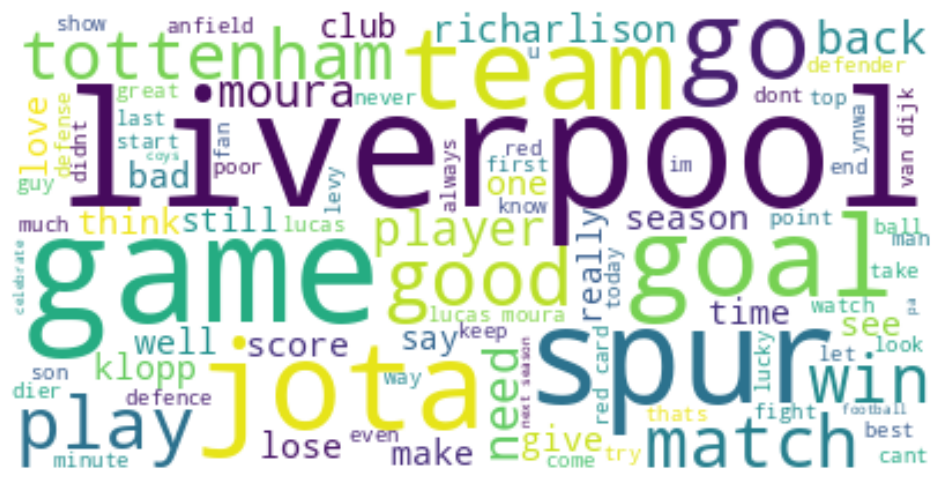

In [ ]:
wordcloudify(current_df)

### Term-frequency analysis

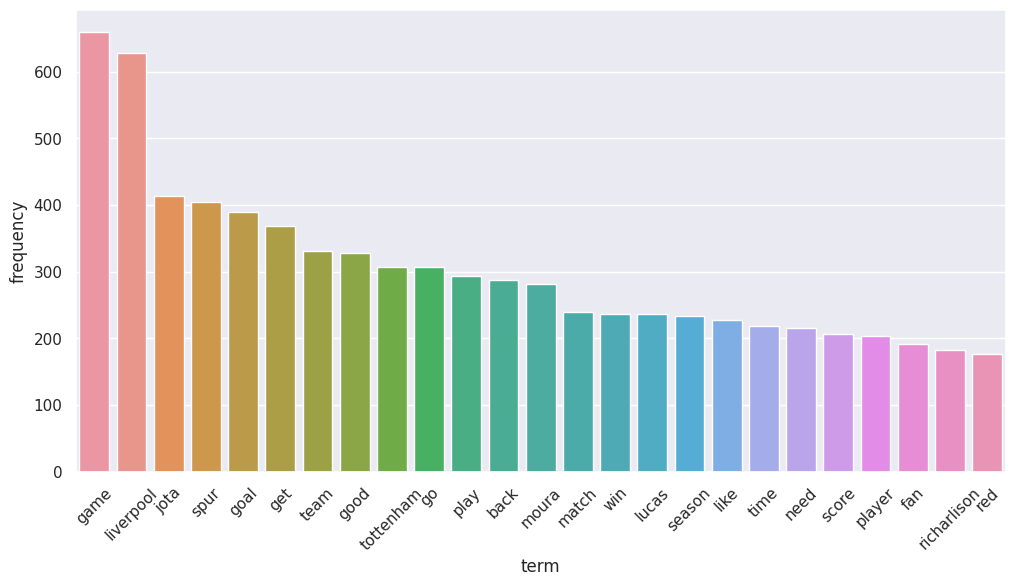

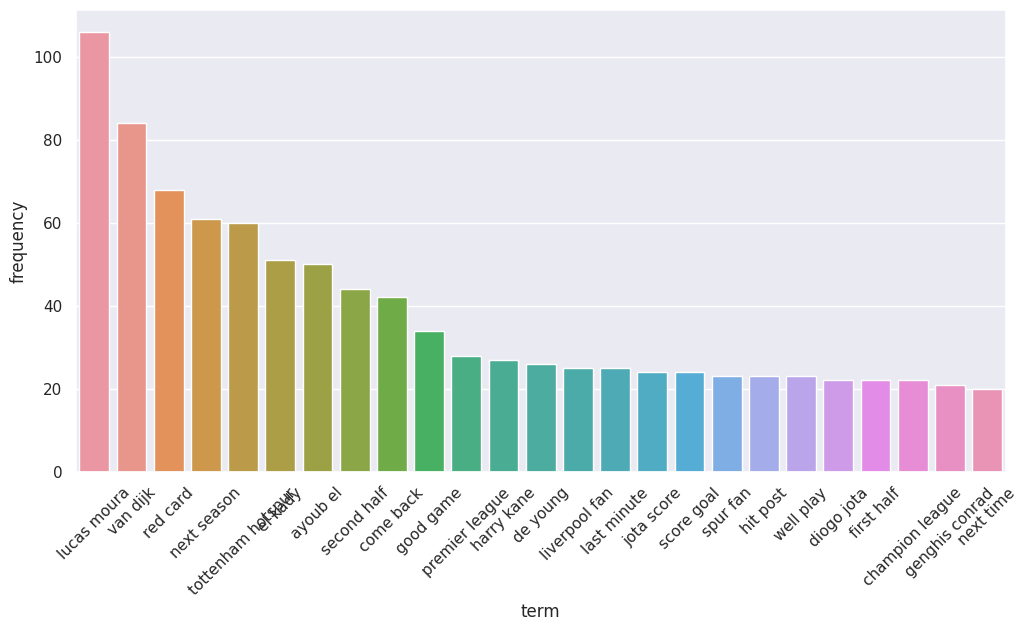

In [ ]:
visualize_terms(current_df)

In [ ]:
frequency_df(current_df, 1).head(10)

term  frequency
0       game        660
1  liverpool        628
2       jota        414
3       spur        404
4       goal        389
5        get        369
6       team        331
7       good        328
8  tottenham        307
9         go        307

In [ ]:
frequency_df(current_df, 2).head(10)

term  frequency
0        lucas moura        106
1           van dijk         84
2           red card         68
3        next season         61
4  tottenham hotspur         60
5            el kady         51
6           ayoub el         50
7        second half         44
8          come back         42
9          good game         34

### Topic Modeling

In [ ]:
liverNCTopic, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

In [ ]:
liverNCTopic.value_counts('Topic').reset_index()

Topic  count
0      2   2189
1      0   1900
2      1   1724

# Manchester Data


## All Manchester Data

In [ ]:
current_df = dfDict['Manchester']

### Wordcloud

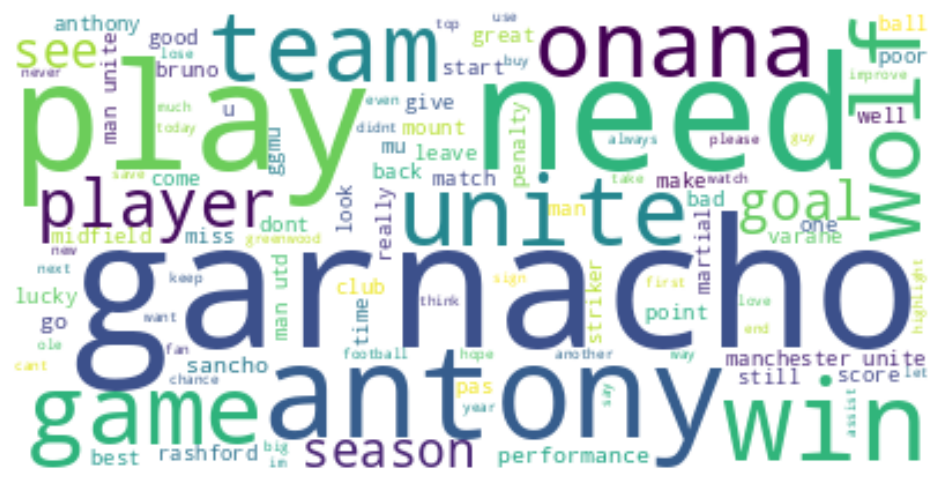

In [ ]:
wordcloudify(current_df)

### Topic Modeling

In [ ]:
manTopics, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

### Sentiment Analysis

In [ ]:
man_analysis = sentiment_analysis(current_df)
man_analysis

Platform                                    Game        Team  \
42064  Youtube     Manchester United vs. Wolves May 14  Manchester   
42065  Youtube     Manchester United vs. Wolves May 14  Manchester   
42066  Youtube     Manchester United vs. Wolves May 14  Manchester   
42067  Youtube     Manchester United vs. Wolves May 14  Manchester   
42068  Youtube     Manchester United vs. Wolves May 14  Manchester   
...        ...                                     ...         ...   
44906  Youtube  Manchester United vs. Wolves August 15  Manchester   
44907  Youtube  Manchester United vs. Wolves August 15  Manchester   
44908  Youtube  Manchester United vs. Wolves August 15  Manchester   
44909  Youtube  Manchester United vs. Wolves August 15  Manchester   
44910  Youtube  Manchester United vs. Wolves August 15  Manchester   

                                       cleaned_text    neg    neu    pos  \
42064          open game season see wolf dominate u  0.231  0.769  0.000   
42065                   hope see cleansheet tonight  0.000  0.508  0.492   
42066   maguire leave antony stayin annoy u man fan  0.394  0.385  0.221   
42067                                       unitedd  0.000  1.000  0.000   
42068                   garnacho real deal cant lie  0.000  1.000  0.000   
...                                             ...    ...    ...    ...   
44906  awb prove deserve start xi ahead diego dalot  0.000  1.000  0.000   
44907                                          good  0.000  0.000  1.000   
44908                                         onana  0.000  1.000  0.000   
44909                            win feel like lose  0.270  0.100  0.630   
44910                           rasford egois plyer  0.000  1.000  0.000   

       compound  
42064   -0.1280  
42065    0.4404  
42066   -0.2023  
42067    0.0000  
42068    0.0000  
...         ...  
44906    0.0000  
44907    0.4404  
44908    0.0000  
44909    0.5574  
44910    0.0000  

[2847 rows x 8 columns]

In [ ]:
man_analysis.groupby('Game').describe()

neg                                \
                                         count      mean       std  min  25%   
Game                                                                           
Manchester United vs. Wolves August 15  1818.0  0.158024  0.234459  0.0  0.0   
Manchester United vs. Wolves May 14     1029.0  0.066474  0.148744  0.0  0.0   

                                                                neu            \
                                        50%      75%    max   count      mean   
Game                                                                            
Manchester United vs. Wolves August 15  0.0  0.27875  1.000  1818.0  0.613865   
Manchester United vs. Wolves May 14     0.0  0.00000  0.857  1029.0  0.743716   

                                        ...    pos      compound            \
                                        ...    75%  max    count      mean   
Game                                    ...                                  
Manchester United vs. Wolves August 15  ...  0.412  1.0   1818.0  0.099919   
Manchester United vs. Wolves May 14     ...  0.350  1.0   1029.0  0.140581   

                                                                               \
                                             std     min     25%  50%     75%   
Game                                                                            
Manchester United vs. Wolves August 15  0.441966 -0.9272 -0.1027  0.0  0.4404   
Manchester United vs. Wolves May 14     0.346957 -0.8750  0.0000  0.0  0.4215   

                                                
                                           max  
Game                                            
Manchester United vs. Wolves August 15  0.9923  
Manchester United vs. Wolves May 14     0.9918  

[2 rows x 32 columns]

In [ ]:
manSenti = current_df.copy()
sentimentalize(man_analysis, manSenti)
manSenti[['Game', 'sentiment']].groupby('Game').value_counts().reset_index()

Game sentiment  count
0  Manchester United vs. Wolves August 15   neutral   1198
1  Manchester United vs. Wolves August 15  positive    383
2  Manchester United vs. Wolves August 15  negative    237
3     Manchester United vs. Wolves May 14   neutral    805
4     Manchester United vs. Wolves May 14  positive    181
5     Manchester United vs. Wolves May 14  negative     43

### Term-frequency based analysis

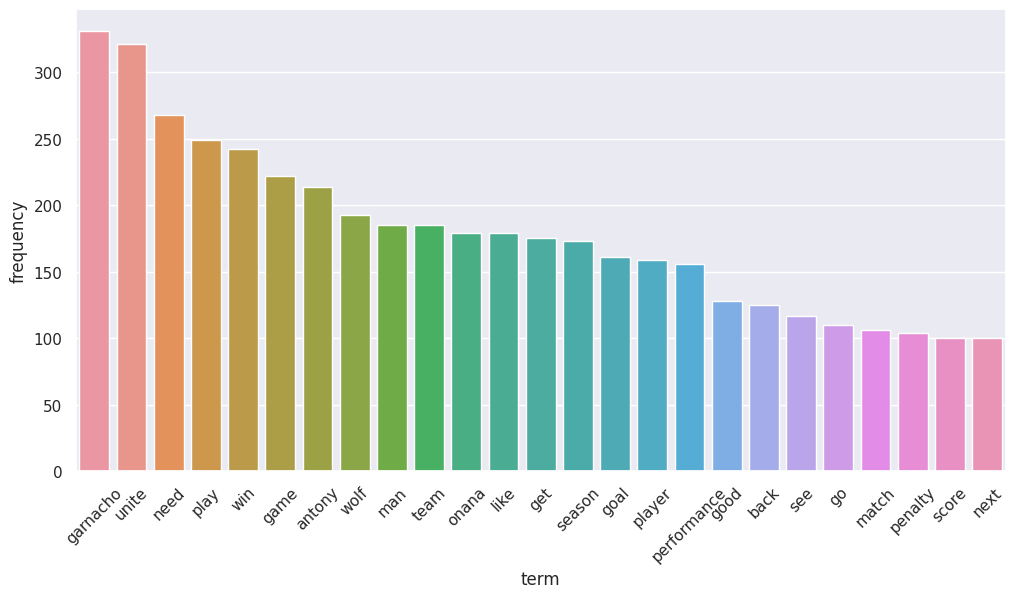

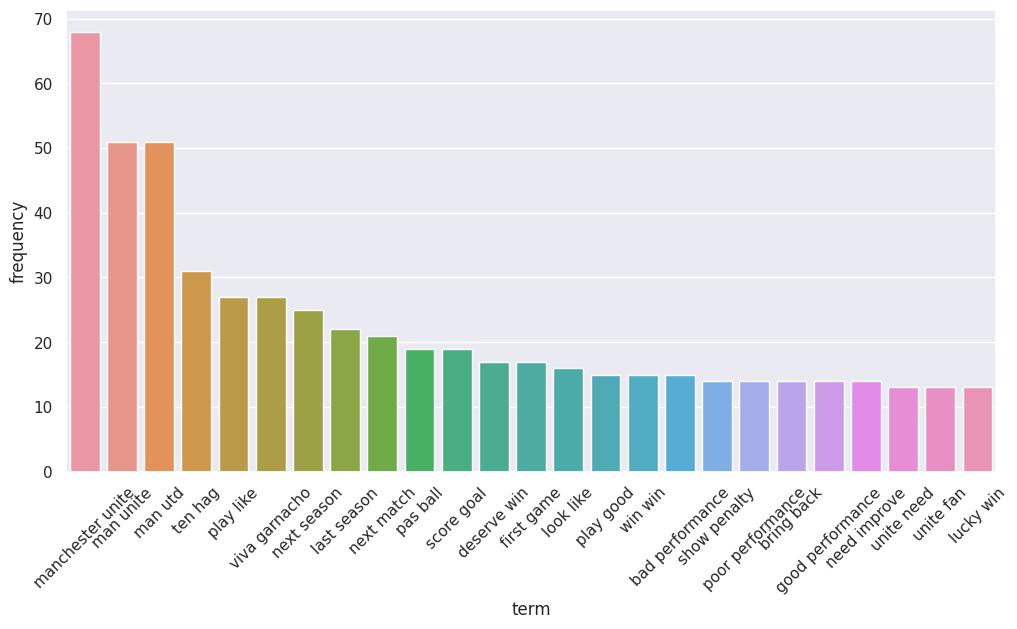

In [ ]:
visualize_terms(current_df)

## Manchester Controversial Data

In [ ]:
current_df = dfDict['Manchester United vs. Wolves August 15, Manchester']

### Wordcloud

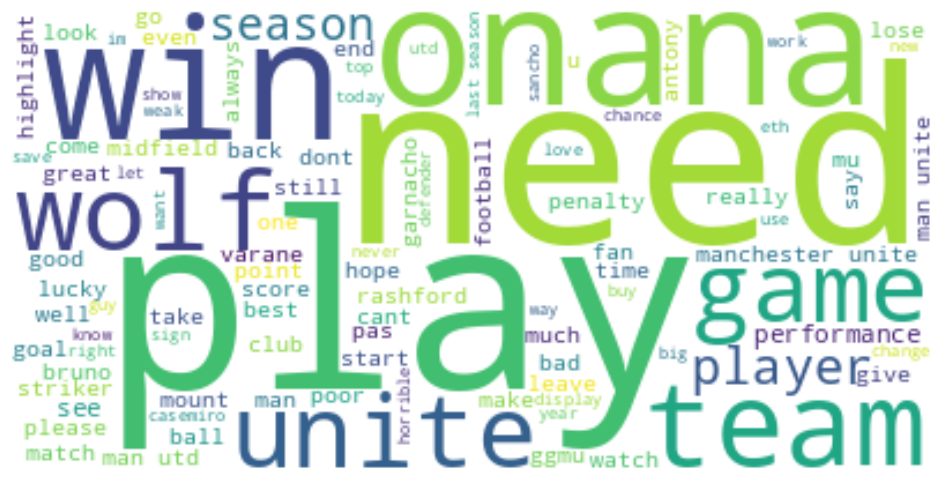

In [ ]:
wordcloudify(current_df)

### Term-frequency based analysis

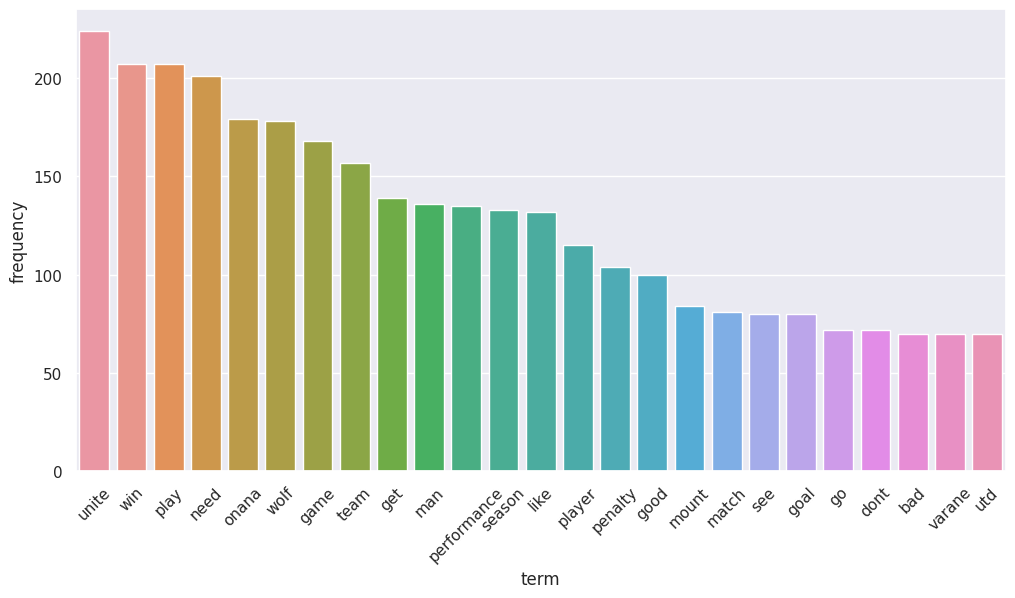

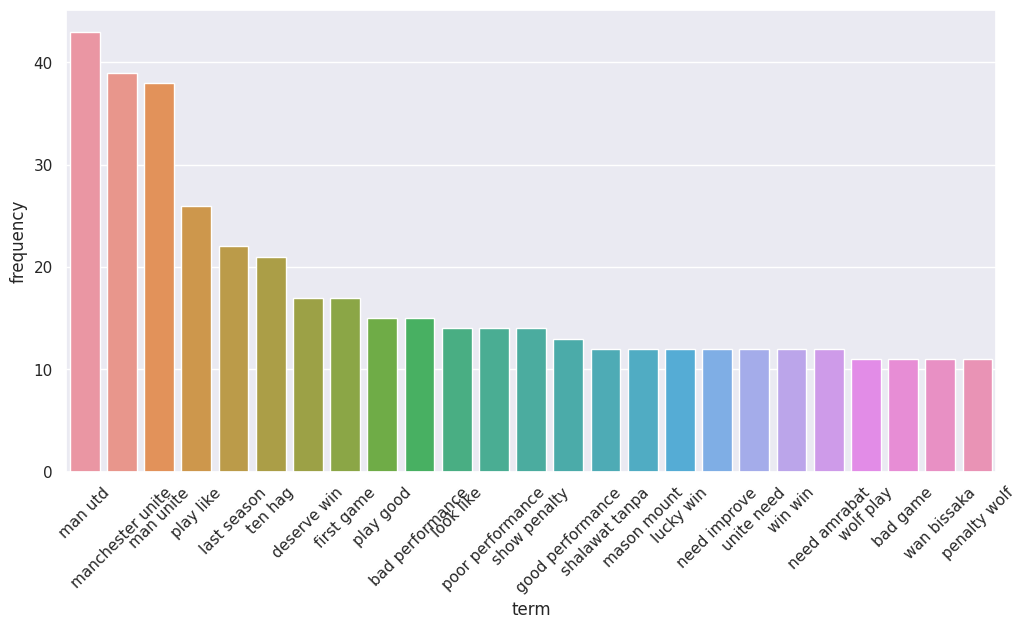

In [ ]:
visualize_terms(current_df)

In [ ]:
frequency_df(current_df, 1).head(10)

term  frequency
0  unite        224
1    win        207
2   play        207
3   need        201
4  onana        179
5   wolf        178
6   game        168
7   team        157
8    get        139
9    man        136

In [ ]:
frequency_df(current_df, 2).head(10)

term  frequency
0           man utd         43
1  manchester unite         39
2         man unite         38
3         play like         26
4       last season         22
5           ten hag         21
6       deserve win         17
7        first game         17
8         play good         15
9   bad performance         15

### Topic Modeling

In [ ]:
manCTopics, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

In [ ]:
manCTopics.value_counts('Topic').reset_index()

Topic  count
0      1    717
1      0    636
2      2    465

## Manchester Non-Controversial Data

In [ ]:
current_df = dfDict['Manchester United vs. Wolves May 14, Manchester']

### Wordcloud

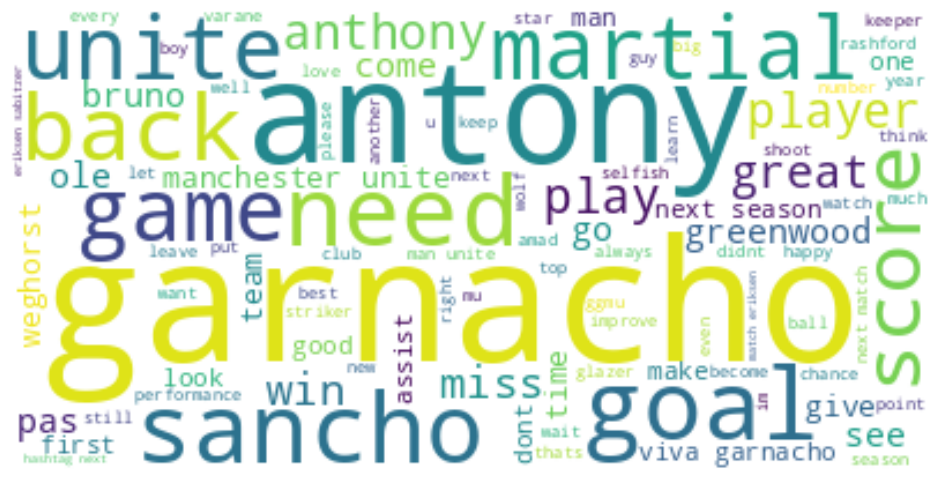

In [ ]:
wordcloudify(current_df)

### Term-frequency analysis

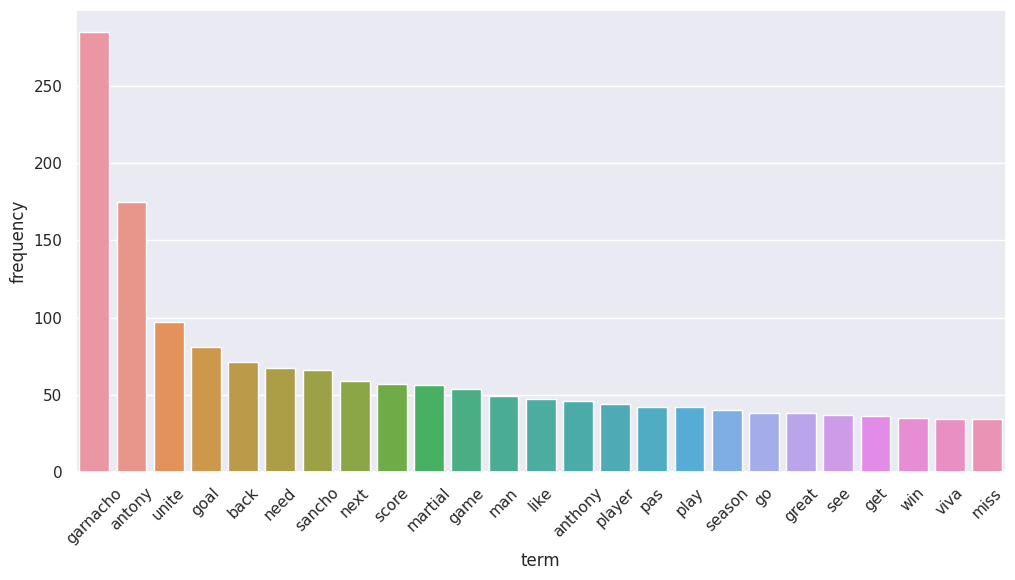

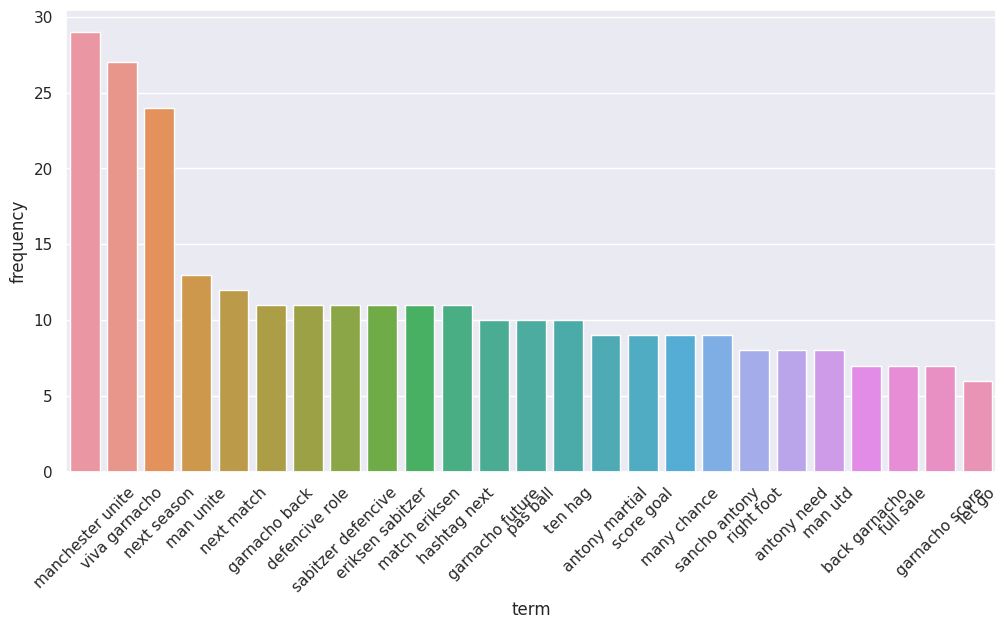

In [ ]:
visualize_terms(current_df)

In [ ]:
frequency_df(current_df, 1).head(10)

term  frequency
0  garnacho        285
1    antony        175
2     unite         97
3      goal         81
4      back         71
5      need         67
6    sancho         66
7      next         59
8     score         57
9   martial         56

In [ ]:
frequency_df(current_df, 2).head(10)

term  frequency
0    manchester unite         29
1       viva garnacho         27
2         next season         24
3           man unite         13
4          next match         12
5       garnacho back         11
6      defencive role         11
7  sabitzer defencive         11
8    eriksen sabitzer         11
9       match eriksen         11

### Topic Modeling

In [ ]:
manNCTopics, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

In [ ]:
manNCTopics.value_counts('Topic').reset_index()

Topic  count
0      1    402
1      0    326
2      2    301

# Wolves Data

## All Wolves Data

In [ ]:
current_df = dfDict['Wolves']

### Topic Modeling

In [ ]:
wolvesTopics, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

### Wordcloud

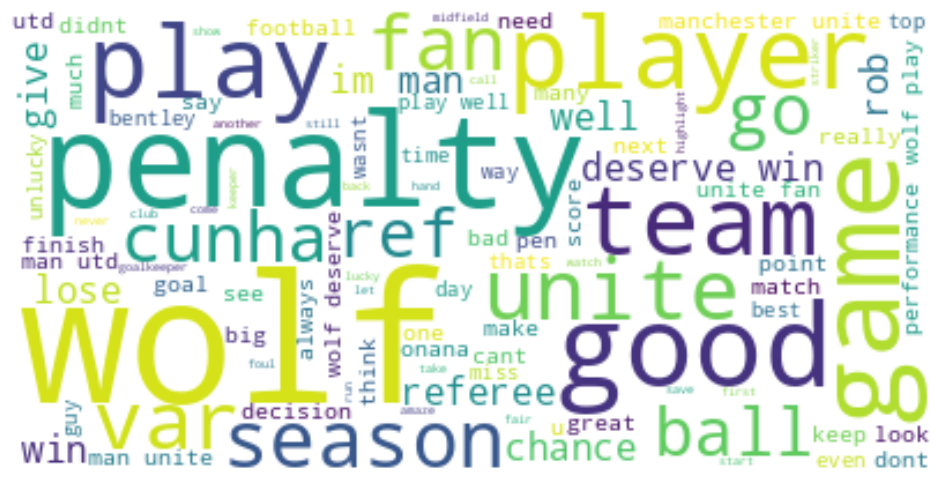

In [ ]:
wordcloudify(current_df)

### Sentiment Analysis

In [ ]:
wol_analysis = sentiment_analysis(current_df)
wol_analysis

Platform                                    Game    Team  \
42012  Youtube     Manchester United vs. Wolves May 14  Wolves   
42013  Youtube     Manchester United vs. Wolves May 14  Wolves   
42014  Youtube     Manchester United vs. Wolves May 14  Wolves   
42015  Youtube     Manchester United vs. Wolves May 14  Wolves   
42016  Youtube     Manchester United vs. Wolves May 14  Wolves   
...        ...                                     ...     ...   
45523  Youtube  Manchester United vs. Wolves August 15  Wolves   
45524  Youtube  Manchester United vs. Wolves August 15  Wolves   
45525  Youtube  Manchester United vs. Wolves August 15  Wolves   
45526  Youtube  Manchester United vs. Wolves August 15  Wolves   
45527  Youtube  Manchester United vs. Wolves August 15  Wolves   

                                            cleaned_text    neg    neu    pos  \
42012                                               wolf  0.000  1.000  0.000   
42013         goalkeeper prove he call bentley class act  0.000  1.000  0.000   
42014  say week get slat lopetegui underwhelming daws...  0.150  0.534  0.316   
42015                                 love wolverhampton  0.000  0.192  0.808   
42016      manchester unite fani apppreciate performance  0.000  1.000  0.000   
...                                                  ...    ...    ...    ...   
45523  brilliant save jose sa open day wolverhampton ...  0.136  0.545  0.318   
45524                                          first one  0.000  1.000  0.000   
45525                                              shame  1.000  0.000  0.000   
45526                             wolf deserve win today  0.000  0.441  0.559   
45527                                          first pin  0.000  1.000  0.000   

       compound  
42012    0.0000  
42013    0.0000  
42014    0.8689  
42015    0.6369  
42016    0.0000  
...         ...  
45523    0.6124  
45524    0.0000  
45525   -0.4767  
45526    0.5859  
45527    0.0000  

[669 rows x 8 columns]

In [ ]:
wol_analysis.groupby('Game').describe()

neg                                \
                                        count      mean       std  min  25%   
Game                                                                          
Manchester United vs. Wolves August 15  617.0  0.177501  0.241813  0.0  0.0   
Manchester United vs. Wolves May 14      52.0  0.118538  0.210585  0.0  0.0   

                                                              neu            \
                                          50%    75%   max  count      mean   
Game                                                                          
Manchester United vs. Wolves August 15  0.065  0.289  1.00  617.0  0.569611   
Manchester United vs. Wolves May 14     0.000  0.155  0.73   52.0  0.579115   

                                        ...     pos       compound            \
                                        ...     75%   max    count      mean   
Game                                    ...                                    
Manchester United vs. Wolves August 15  ...  0.4340  1.00    617.0  0.139633   
Manchester United vs. Wolves May 14     ...  0.5945  0.83     52.0  0.277321   

                                                                        \
                                             std     min     25%   50%   
Game                                                                     
Manchester United vs. Wolves August 15  0.475251 -0.9118 -0.1531  0.00   
Manchester United vs. Wolves May 14     0.502138 -0.8979  0.0000  0.35   

                                                        
                                           75%     max  
Game                                                    
Manchester United vs. Wolves August 15  0.5859  0.9674  
Manchester United vs. Wolves May 14     0.7485  0.9709  

[2 rows x 32 columns]

In [ ]:
wolSenti = current_df.copy()
sentimentalize(wol_analysis, wolSenti)
wolSenti[['Game', 'sentiment']].groupby('Game').value_counts().reset_index()

Game sentiment  count
0  Manchester United vs. Wolves August 15   neutral    397
1  Manchester United vs. Wolves August 15  positive    141
2  Manchester United vs. Wolves August 15  negative     79
3     Manchester United vs. Wolves May 14   neutral     30
4     Manchester United vs. Wolves May 14  positive     16
5     Manchester United vs. Wolves May 14  negative      6

### Term-frequency based analysis

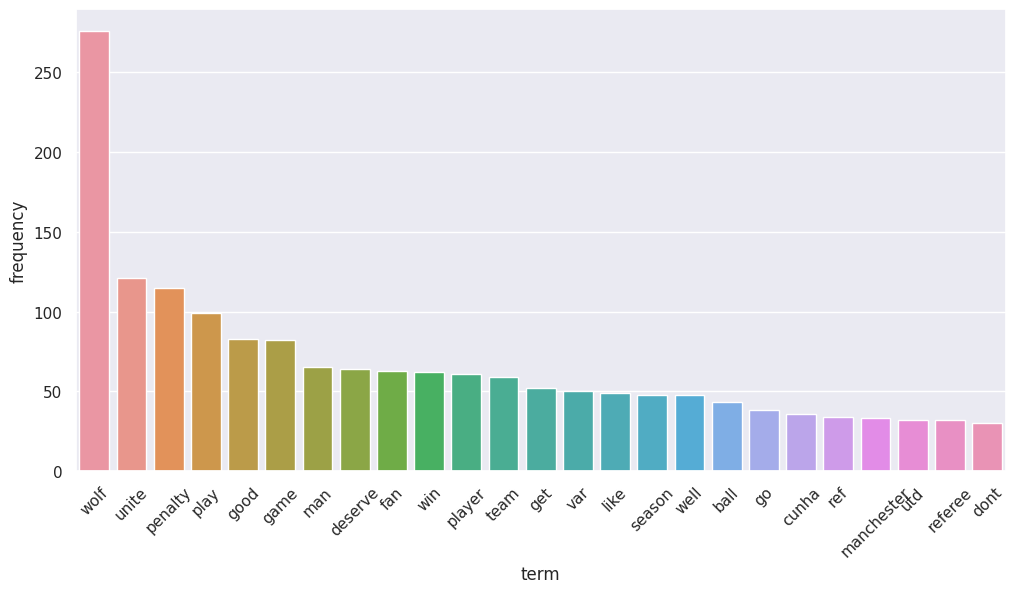

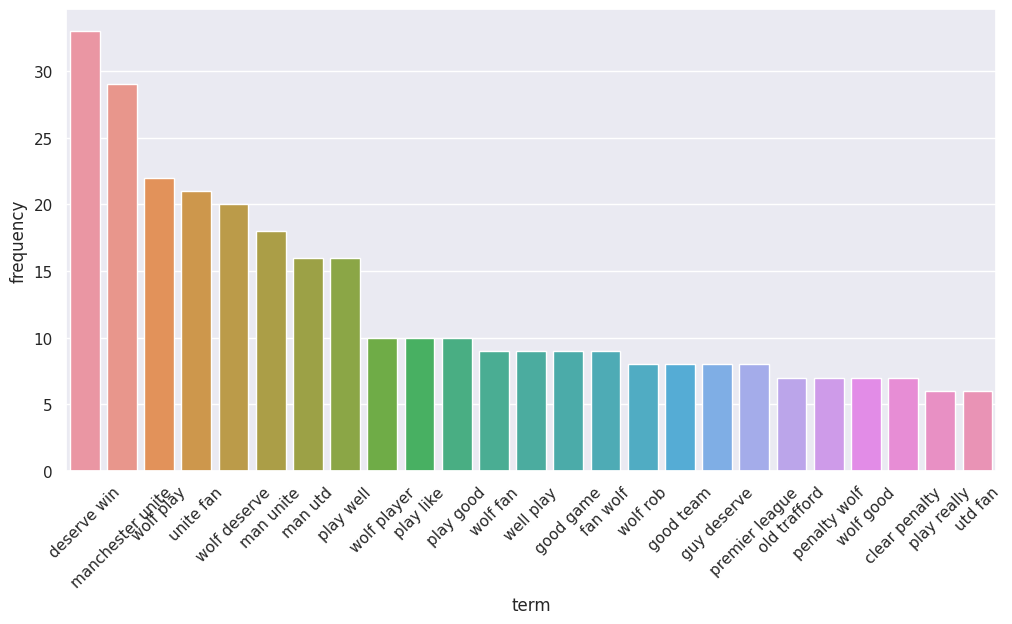

In [ ]:
visualize_terms(current_df)

## Wolves Controversial Data

In [ ]:
current_df = dfDict['Manchester United vs. Wolves August 15, Wolves']

### Wordcloud

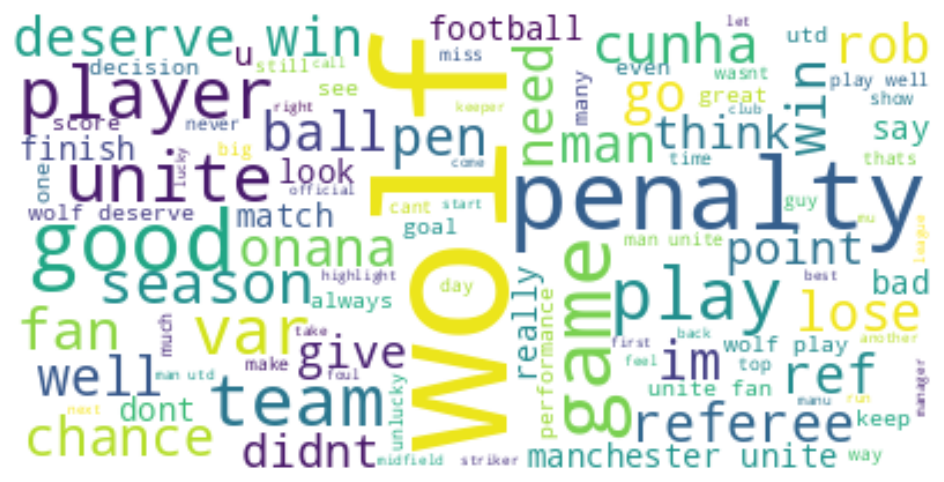

In [ ]:
wordcloudify(current_df)

### Term-frequency Analysis

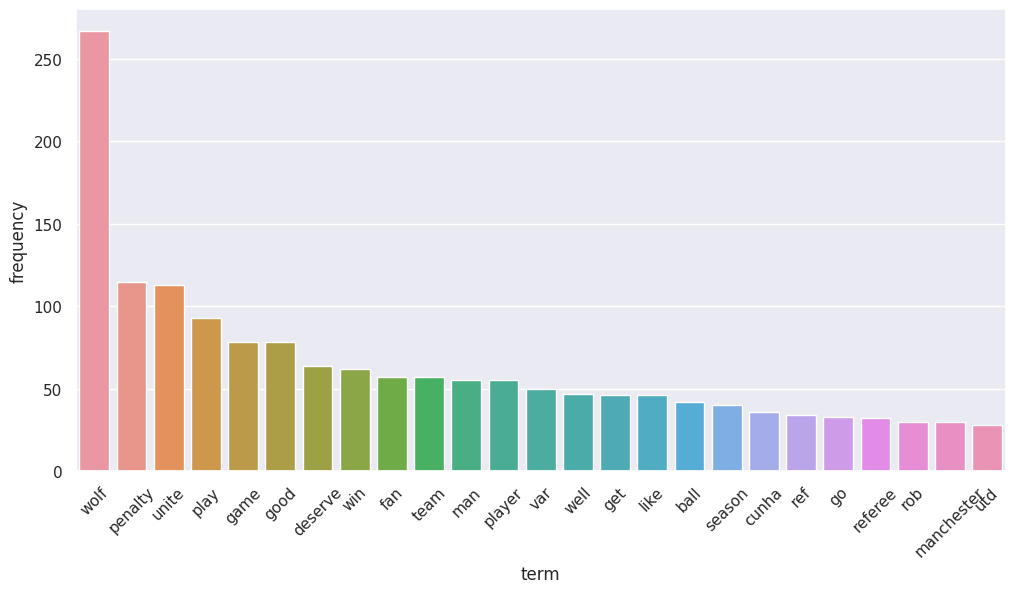

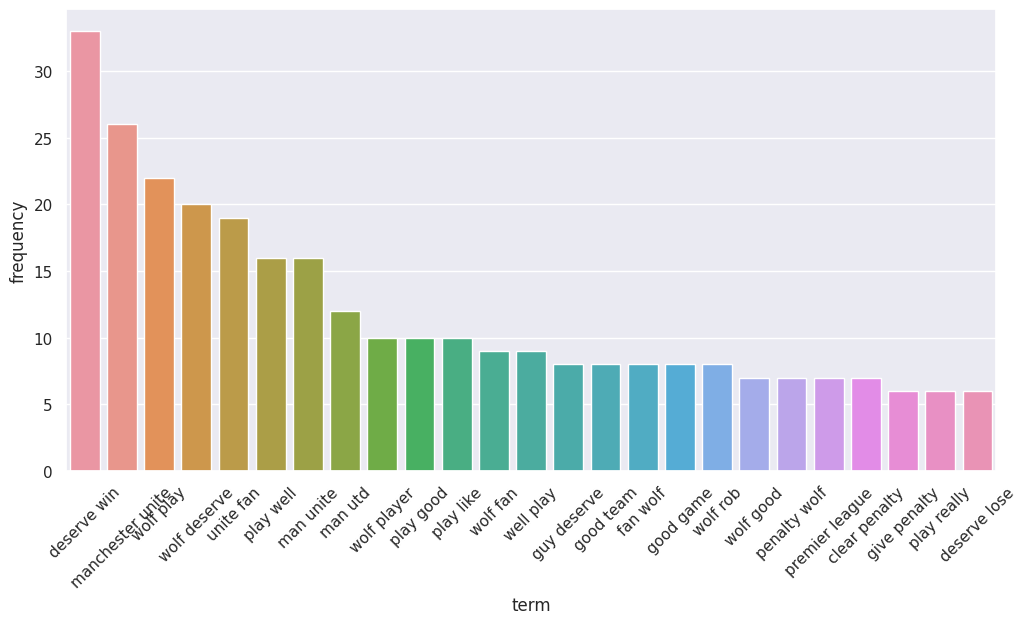

In [ ]:
visualize_terms(current_df)

In [ ]:
frequency_df(current_df, 1).head(10)

term  frequency
0     wolf        267
1  penalty        115
2    unite        113
3     play         93
4     game         78
5     good         78
6  deserve         64
7      win         62
8      fan         57
9     team         57

In [ ]:
frequency_df(current_df, 2).head(10)

term  frequency
0       deserve win         33
1  manchester unite         26
2         wolf play         22
3      wolf deserve         20
4         unite fan         19
5         play well         16
6         man unite         16
7           man utd         12
8       wolf player         10
9         play good         10

### Topic Modeling

In [ ]:
wolvesCTopics, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

In [ ]:
wolvesCTopics.value_counts('Topic').reset_index()

Topic  count
0      2    305
1      0    157
2      1    155

## Wolves Non-Controversial Data

In [ ]:
current_df = dfDict['Manchester United vs. Wolves May 14, Wolves']

### Wordcloud

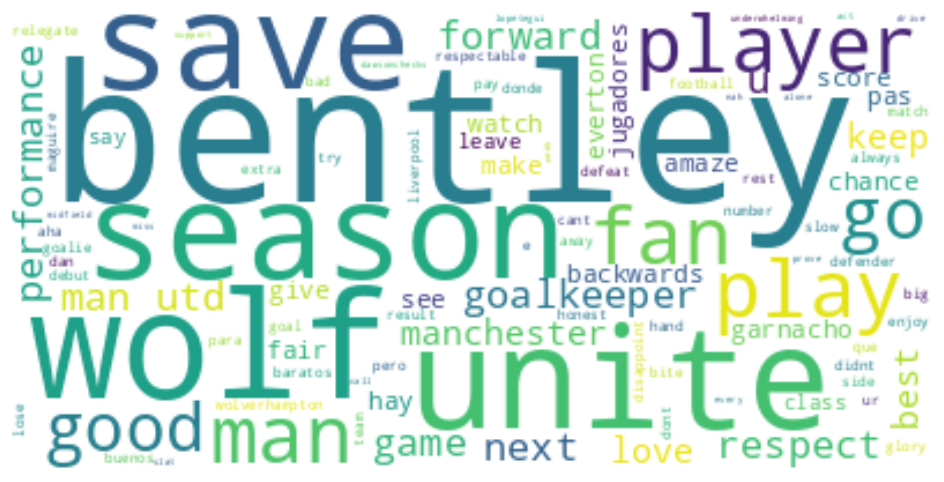

In [ ]:
wordcloudify(current_df)

### Term-frequency Analysis

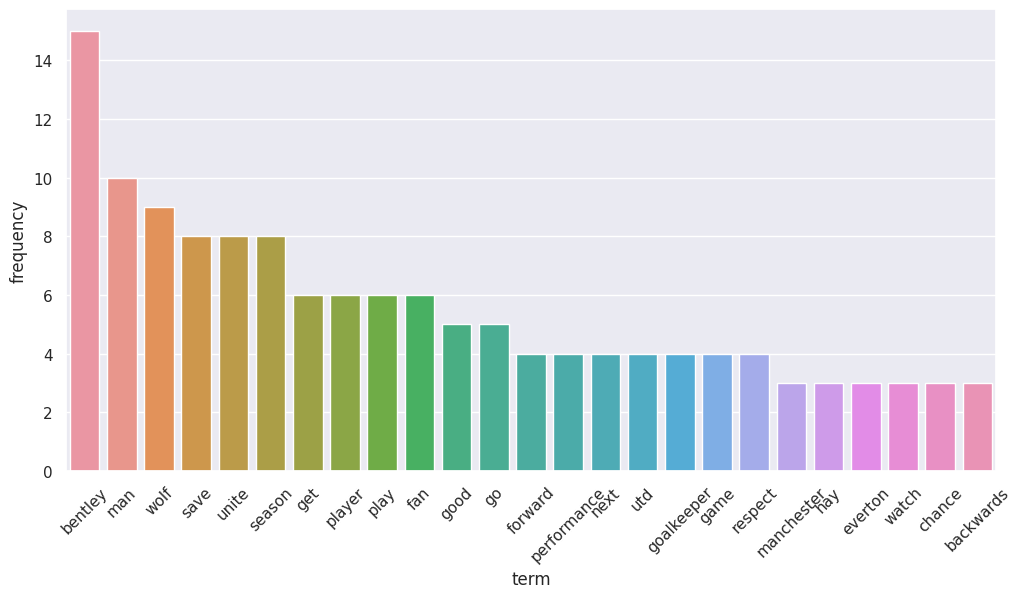

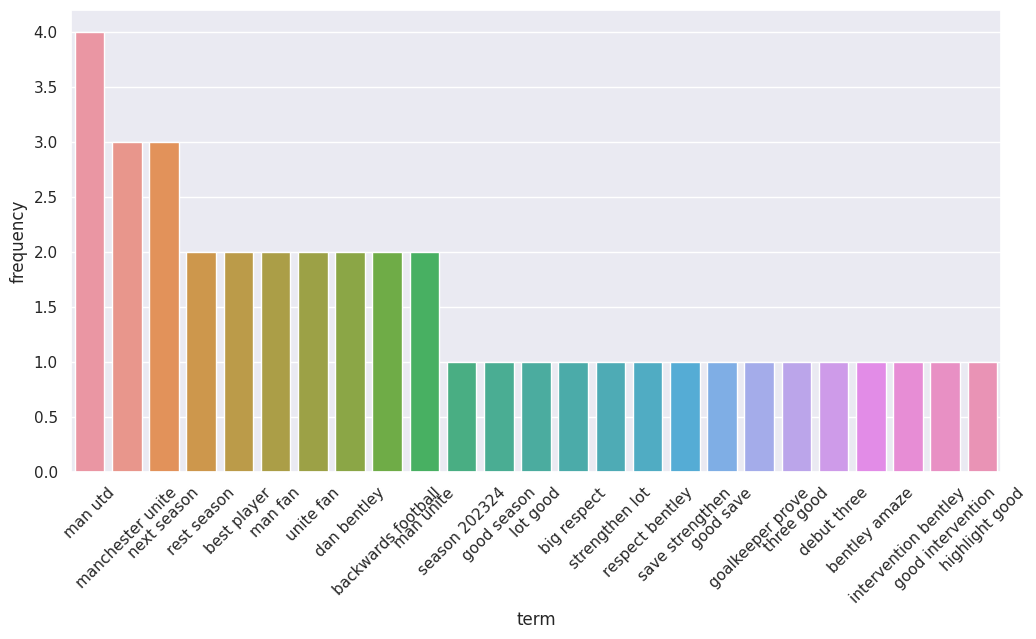

In [ ]:
visualize_terms(current_df)

In [ ]:
frequency_df(current_df, 1).head(10)

term  frequency
0  bentley         15
1      man         10
2     wolf          9
3     save          8
4    unite          8
5   season          8
6      get          6
7   player          6
8     play          6
9      fan          6

In [ ]:
frequency_df(current_df, 2).head(10)

term  frequency
0             man utd          4
1    manchester unite          3
2         next season          3
3         rest season          2
4         best player          2
5             man fan          2
6           unite fan          2
7         dan bentley          2
8  backwards football          2
9           man unite          2

### Topic Modeling

In [ ]:
wolvesNCTopics, topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs = topic_model(current_df, 3)
pyLDAvis.display(pyLDAvis.prepare(topic_term_matrix , doc_topic_matrix, doc_lengths, vocab, term_freqs))

In [ ]:
wolvesNCTopics.value_counts('Topic').reset_index()

Topic  count
0      0     25
1      2     19
2      1      8